In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



LOAD AND PROCESS DATASET

In [22]:
image_size = (256, 256)
batch_size = 32

# Load dataset
data_dir = "dataset_images"
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Split dataset
dataset_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

# Normalize data
def normalize(images, labels):
    images = tf.image.per_image_standardization(images)  # Normalize images
    return images, labels

train_data = train_data.map(normalize)
val_data = val_data.map(normalize)
test_data = test_data.map(normalize)


Found 2254 files belonging to 6 classes.


COMPUTE CLASS WEIGHTS

In [ ]:
labels = []
for _, label in data.unbatch():
    labels.append(label.numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.8009950248756219), 1: np.float64(1.0733333333333333), 2: np.float64(0.624031007751938), 3: np.float64(0.9757575757575757), 4: np.float64(1.3089430894308942), 5: np.float64(2.3333333333333335)}


Create the model using transfer learning

In [ ]:
# 3. Create the model using transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer
    layers.Dense(len(data.class_names), activation='softmax')  # Output layer
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\fab\AppData\Local\Temp\ipykernel_30736\3688060426.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),


Train the model

In [25]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights_dict
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4004 - loss: 1.8903 - val_accuracy: 0.8884 - val_loss: 0.3748
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7759 - loss: 0.6228 - val_accuracy: 0.9420 - val_loss: 0.2167
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8398 - loss: 0.4668 - val_accuracy: 0.9397 - val_loss: 0.1873
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8644 - loss: 0.3781 - val_accuracy: 0.9464 - val_loss: 0.1598
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8800 - loss: 0.3319 - val_accuracy: 0.9531 - val_loss: 0.1275
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8984 - loss: 0.3109 - val_accuracy: 0.9464 - val_loss: 0.1466
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9173 - loss: 0.2407 - val_accuracy: 0.9509 - val_loss: 0.1083
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 924ms/step - accuracy: 0.9221 - loss: 0.2145 - val_accuracy: 0.9509 - val_lo

Evaluate the model

In [26]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.9715 - loss: 0.0780
Test Accuracy: 96.64%


Confusion matrix and visualization

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 680ms/step


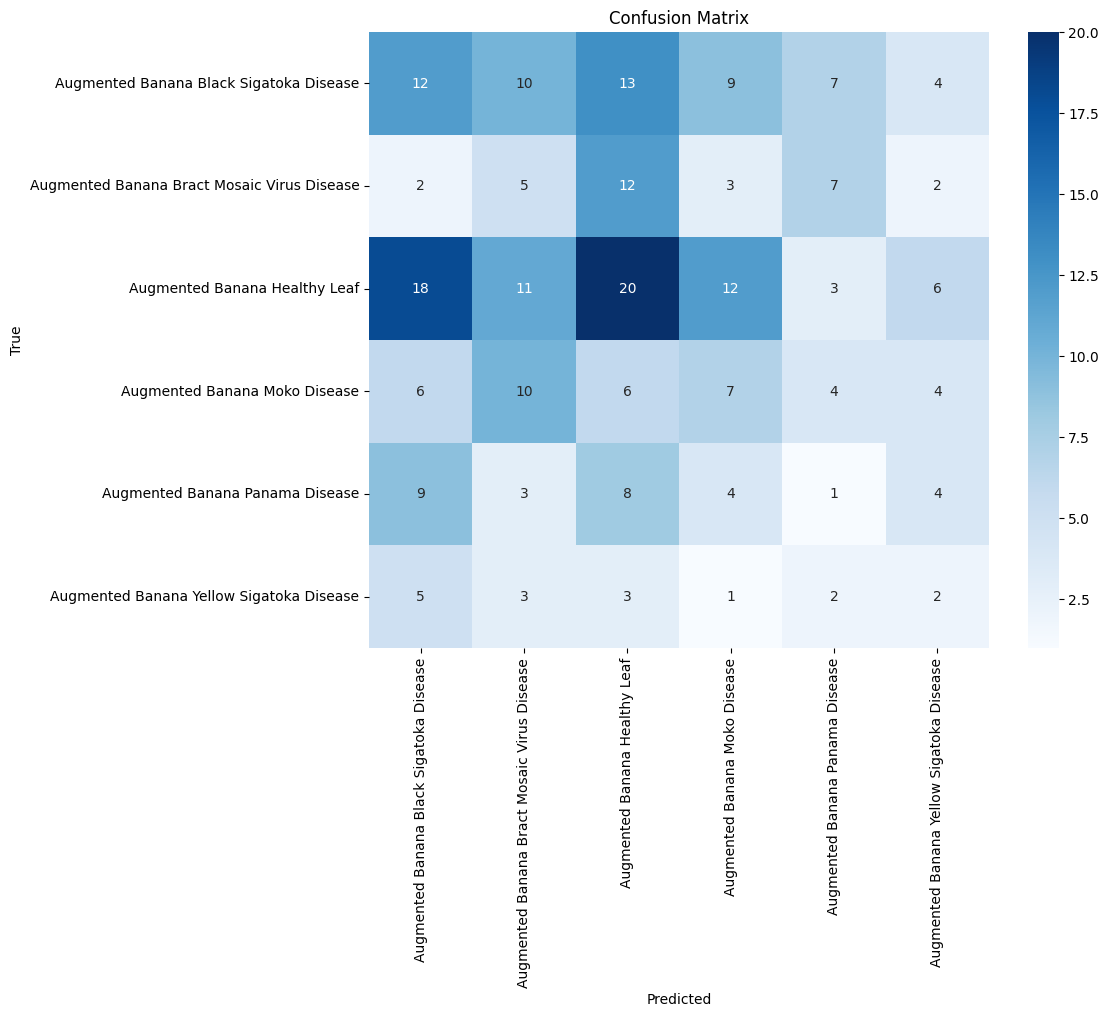

In [55]:
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(len(data.class_names)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.class_names, 
            yticklabels=data.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



Predict on a single image

In [53]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read the file {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, image_size)  # Resize to target size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_class = data.class_names[np.argmax(prediction)]
    print(f"Predicted Class: {predicted_class}")

# Example prediction
predict_image("black.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Class: Augmented Banana Bract Mosaic Virus Disease
